# Big O Notation: Demostración Empírica con Algoritmos de Búsqueda

En este notebook verificamos experimentalmente que los algoritmos de búsqueda se comportan según predice la **notación Big O**:

| Algoritmo | Complejidad | Descripción |
|---|---|---|
| Búsqueda lineal | $O(n)$ | Recorre todos los elementos uno a uno |
| Búsqueda 2 en 2 | $O(n)$ | Recorre pares e impares por separado (sigue siendo lineal) |
| Búsqueda binaria | $O(\log n)$ | Divide el espacio de búsqueda a la mitad en cada paso |

Medimos tiempos de ejecución reales para distintos tamaños de entrada $n$ y graficamos los resultados para comparar con las curvas teóricas.

In [1]:
from __future__ import annotations

import random
import time
from typing import List, Optional, Callable, Tuple

import matplotlib.pyplot as plt

### Dependencias

- `random`: generación de datos aleatorios para las pruebas
- `time`: medición de tiempos de ejecución (`perf_counter`)
- `gc`: control del garbage collector para reducir ruido en las mediciones
- `matplotlib`: visualización de resultados

## 1) Algoritmos de búsqueda

Implementamos tres algoritmos que buscan un valor `target` dentro de un arreglo y retornan su índice (o `None` si no se encuentra).

### 1.1 Búsqueda lineal — $O(n)$

Recorre el arreglo elemento por elemento desde el inicio hasta encontrar el objetivo o agotar todos los elementos.

**Pseudocódigo:**
```
FUNCIÓN linear_search(arr, target):
    PARA i ← 0 HASTA longitud(arr) - 1:
        SI arr[i] == target:
            RETORNAR i
    RETORNAR None
```

**Peor caso:** el elemento no está en el arreglo → se revisan los $n$ elementos → $O(n)$.

In [2]:
def linear_search(arr: List[int], target: int) -> Optional[int]:
    """O(n): revisa elemento por elemento."""
    for i, x in enumerate(arr):
        if x == target:
            return i
    return None

### 1.2 Búsqueda 2 en 2 — $O(n)$

Divide el recorrido en dos pasadas: primero los índices pares (0, 2, 4, ...) y luego los impares (1, 3, 5, ...). Aunque cambia el orden de acceso, **sigue visitando todos los elementos** en el peor caso, por lo que la complejidad permanece $O(n)$.

**Pseudocódigo:**
```
FUNCIÓN two_by_two_search(arr, target):
    n ← longitud(arr)

    // Primera pasada: índices pares
    PARA i ← 0 HASTA n-1, PASO 2:
        SI arr[i] == target:
            RETORNAR i

    // Segunda pasada: índices impares
    PARA i ← 1 HASTA n-1, PASO 2:
        SI arr[i] == target:
            RETORNAR i

    RETORNAR None
```

**Peor caso:** $\frac{n}{2} + \frac{n}{2} = n$ comparaciones → $O(n)$. El recorrido es diferente pero el orden asintótico es idéntico al de la búsqueda lineal.

In [3]:
def two_by_two_search(arr: List[int], target: int) -> Optional[int]:
    """
    O(n): recorre 'de 2 en 2' (pares) y luego (impares).
    Esto NO mejora el orden asintótico, pero es útil para comparar recorridos.
    """
    n = len(arr)

    # 1) índices pares: 0,2,4,...
    for i in range(0, n, 2):
        if arr[i] == target:
            return i

    # 2) índices impares: 1,3,5,...
    for i in range(1, n, 2):
        if arr[i] == target:
            return i

    return None

### 1.3 Búsqueda binaria — $O(\log n)$

Requiere que el arreglo esté **ordenado**. En cada iteración compara el elemento central con el objetivo y descarta la mitad del arreglo donde no puede estar.

**Pseudocódigo:**
```
FUNCIÓN binary_search(arr_sorted, target):
    lo ← 0
    hi ← longitud(arr_sorted) - 1

    MIENTRAS lo ≤ hi:
        mid ← (lo + hi) / 2      // división entera
        SI arr_sorted[mid] == target:
            RETORNAR mid
        SI arr_sorted[mid] < target:
            lo ← mid + 1          // descartar mitad izquierda
        SINO:
            hi ← mid - 1          // descartar mitad derecha

    RETORNAR None
```

**Peor caso:** en cada paso el espacio se reduce a la mitad → $\log_2(n)$ iteraciones → $O(\log n)$.

In [4]:
def binary_search(arr_sorted: List[int], target: int) -> Optional[int]:
    """O(log n): requiere arr_sorted ordenada."""
    lo, hi = 0, len(arr_sorted) - 1
    while lo <= hi:
        mid = (lo + hi) // 2
        v = arr_sorted[mid]
        if v == target:
            return mid
        if v < target:
            lo = mid + 1
        else:
            hi = mid - 1
    return None

## 2) Benchmark (medición de tiempos)

Para medir el rendimiento real de cada algoritmo, ejecutamos cada búsqueda múltiples veces y calculamos el **tiempo promedio**. Esto reduce el ruido causado por el sistema operativo, caché del CPU, etc.

**Pseudocódigo:**
```
FUNCIÓN mean_time_seconds(fn, arr, target, repeats):
    desactivar_garbage_collector()

    t0 ← tiempo_actual()
    PARA _ ← 1 HASTA repeats:
        fn(arr, target)
    t1 ← tiempo_actual()

    activar_garbage_collector()
    RETORNAR (t1 - t0) / repeats
```

Se desactiva el **garbage collector** durante la medición para evitar que sus pausas aleatorias distorsionen los tiempos.

In [5]:
def mean_time_seconds(fn: Callable[[List[int], int], Optional[int]],
                      arr: List[int],
                      target: int,
                      repeats: int = 50) -> float:
    """
    Ejecuta fn(arr, target) repeats veces y retorna el tiempo promedio (segundos).
    """
    
    t0 = time.perf_counter()
    for _ in range(repeats):
        fn(arr, target)
    t1 = time.perf_counter()

    return (t1 - t0) / repeats

## 3) Simulación

Generamos arreglos aleatorios de tamaños crecientes y medimos el tiempo promedio de cada algoritmo de búsqueda. Buscamos un `target` aleatorio (que puede o no estar en el arreglo) para simular el **peor/caso promedio**.

**Pseudocódigo del experimento:**
```
FUNCIÓN run_experiment(sizes, repeats, seed):
    PARA CADA n EN sizes:
        arr ← arreglo_aleatorio(tamaño=n)
        target ← valor_aleatorio()
        arr_sorted ← ordenar(arr)

        t_linear[n]  ← mean_time_seconds(linear_search, arr, target, repeats)
        t_two[n]     ← mean_time_seconds(two_by_two_search, arr, target, repeats)
        t_bin[n]     ← mean_time_seconds(binary_search, arr_sorted, target, repeats)

    RETORNAR sizes, t_linear, t_two, t_bin
```

> **Nota:** el tiempo de `sorted(arr)` no se incluye en la medición de búsqueda binaria, ya que solo medimos el costo de la búsqueda en sí.

In [6]:
def run_experiment(
    sizes: List[int],
    repeats: int = 50,
    value_range_factor: int = 10,
    seed: int = 1234,
) -> Tuple[List[int], List[float], List[float], List[float]]:
    """
    Genera listas aleatorias y mide tiempos promedio para:
    - búsqueda lineal
    - búsqueda 2 en 2 (pares+impares)
    - búsqueda binaria (en lista ordenada)
    """
    rng = random.Random(seed)

    t_linear = []
    t_two = []
    t_bin = []

    for n in sizes:
        # Rango de valores relativamente grande para evitar demasiados duplicados
        value_range = max(10, n * value_range_factor)

        arr = [rng.randrange(0, value_range) for _ in range(n)]
        target = rng.randrange(0, value_range)

        # Para binary search necesitamos lista ordenada
        arr_sorted = sorted(arr)

        # Medimos SOLO la búsqueda (no el sort)
        t_linear.append(mean_time_seconds(linear_search, arr, target, repeats=repeats))
        t_two.append(mean_time_seconds(two_by_two_search, arr, target, repeats=repeats))
        t_bin.append(mean_time_seconds(binary_search, arr_sorted, target, repeats=repeats))

    return sizes, t_linear, t_two, t_bin

### Visualización

Graficamos los tiempos en **escala log-log**. En esta escala:
- Un algoritmo $O(n)$ aparece como una **recta con pendiente 1**
- Un algoritmo $O(\log n)$ aparece como una curva que **crece mucho más lentamente**

Esto permite verificar visualmente que los algoritmos lineales y el logarítmico se comportan según la teoría.

In [7]:
def plot_results(sizes: List[int],
                 t_linear: List[float],
                 t_two: List[float],
                 t_bin: List[float]) -> None:
    plt.figure(figsize=(9, 5))

    us = 1e6
    plt.plot(sizes, [x * us for x in t_linear], marker="o", label="Lineal (O(n))")
    plt.plot(sizes, [x * us for x in t_two], marker="o", label="2 en 2 (O(n))")
    plt.plot(sizes, [x * us for x in t_bin], marker="o", label="Binaria (O(log n))")

    plt.xscale("log")  # útil para ver bien crecimiento (5 → 10000)
    plt.yscale("log")  # opcional: resalta diferencias asintóticas
    plt.xlabel("Número de elementos (n) [escala log]")
    plt.ylabel("Tiempo promedio por búsqueda (μs) [escala log]")
    plt.title("Comparación de tiempos: búsqueda lineal vs 2 en 2 vs binaria")
    plt.grid(True, which="both", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


### Ejecución

Corremos el experimento con tamaños desde $n=5$ hasta $n=10{,}000$ y 300 repeticiones por medición:

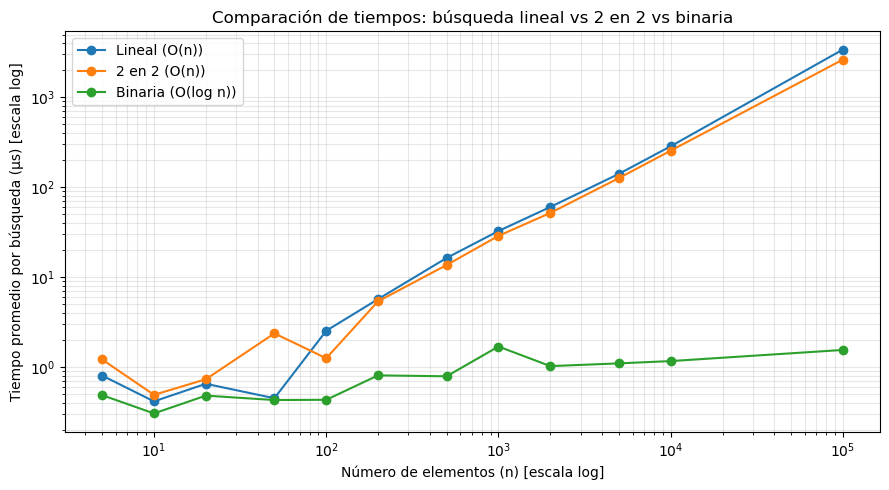

In [8]:
sizes = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 100000]
sizes, t_linear, t_two, t_bin = run_experiment(
    sizes=sizes,
    repeats=300,            
    value_range_factor=10,  
    seed=42,
)
plot_results(sizes, t_linear, t_two, t_bin)

## Conclusiones

- **Búsqueda lineal y 2 en 2** crecen de forma proporcional a $n$, confirmando su complejidad $O(n)$. Ambas curvas tienen pendiente similar en escala log-log.
- **Búsqueda binaria** crece mucho más lento ($O(\log n)$), lo que se observa como una curva casi plana comparada con las lineales.
- La búsqueda 2 en 2 no mejora el orden asintótico respecto a la lineal: reorganizar el recorrido no cambia la cantidad total de trabajo en el peor caso.